# Reproducible Boolean model analyses and simulations with the CoLoMoTo software suite - a tutorial

Vincent Noël<sup>1</sup>, Aurélien Naldi<sup>2</sup>, Laurence Calzone<sup>1,#</sup>,  Loic Paulevé<sup>3,#</sup>, Denis Thieffry<sup>1,2,#</sup>   

<sup>1</sup> Institut Curie, INSERM U900, Mines Paris, PSL Université, Paris, France.   
<sup>2</sup> Département de biologie, PSL Université, Paris, France.   
<sup>3</sup> LaBRI, CNRS UMR 5800, INP, Université de Bordeaux,Talence, France.   
<sup>#</sup> These authors contributed equally to the study.



## Abstract
This tutorial provides step-wise instructions to install the 20 tools integrated in the CoLoMoTo software suite, to develop reproducible dynamical analyses of logical models of complex biological molecular networks.   
The tutorial specifically focuses on the analysis of a previously published model of the regulatory network controlling mammalian cell proliferation. It includes chunks of python code to reproduce several of the results and figures published in the original article and further extend these results with the help of a selection of tools included in the CoLoMoTo suite. 
The notebook covers the visualisation of the network with the tool GINsim, an attractor analysis with bioLQM, the computation of synchronous attractors with BNS, the extraction of modules from the full model, MaBoSS simulations of the wild-type model, as well as of selected mutants, and finally the delineation of compressed probabilistic state transition graphs.  
The integration of all these analyses in an executable Jupyter notebook greatly eases their reproducibility, as well as the inclusion of further extensions. This notebook can further be used as a template and enriched with other ColoMoTo tools to enable comprehensive dynamical analyses of biological network models.  

## 1. Introduction
Since the seminal studies from Motoyosi Sugita [1], Stuart Kauffman [2] and René Thomas [3], Boolean models have been increasingly applied to biological signalling and regulatory networks [4, 5,6, 7). With the rise of high-throughput functional genomic methods and the development of molecular pathway knowledge databases, modellers are now coping with networks encompassing hundreds of regulatory components controlling cell fate decisions for normal and pathological conditions (see e.g. [8]).  
In parallel, dozens of computational tools have been developed to infer, edit and analyse the dynamical properties of Boolean networks, using different programming languages and model formats (see e.g. [9] and references therein). However, like experimental biologists, modellers are facing serious reproducibility challenges, which have been stressed in recent years (see[10], focusing on modelling studies using ordinary differential equations).  
About a decade ago, several international teams working on the development of Boolean modelling tools gathered efforts to address these challenges. The aim was to delineate a common standard format to foster the exchange and reuse of qualitative models between different software tools, which took the form of a dedicated extension of a new, modular release of the popular SBML format, known as sbml-qual [11].  
The second effort was put on the integration of a growing set of tools in a *Docker* container to ease their installation and articulation in flexible analysis workflows. The first release of the resulting *Common Logical Modelling Toolbox* (or *CoLoMoTo*) encompassed six complementary software tools [12]. Since then, the number of tools integrated into the *CoLoMoTo* suite has been constantly increasing, reaching a total of twenty in 2024. The tools currently integrated in the suite are listed in **Figure 1**, with key characteristics.

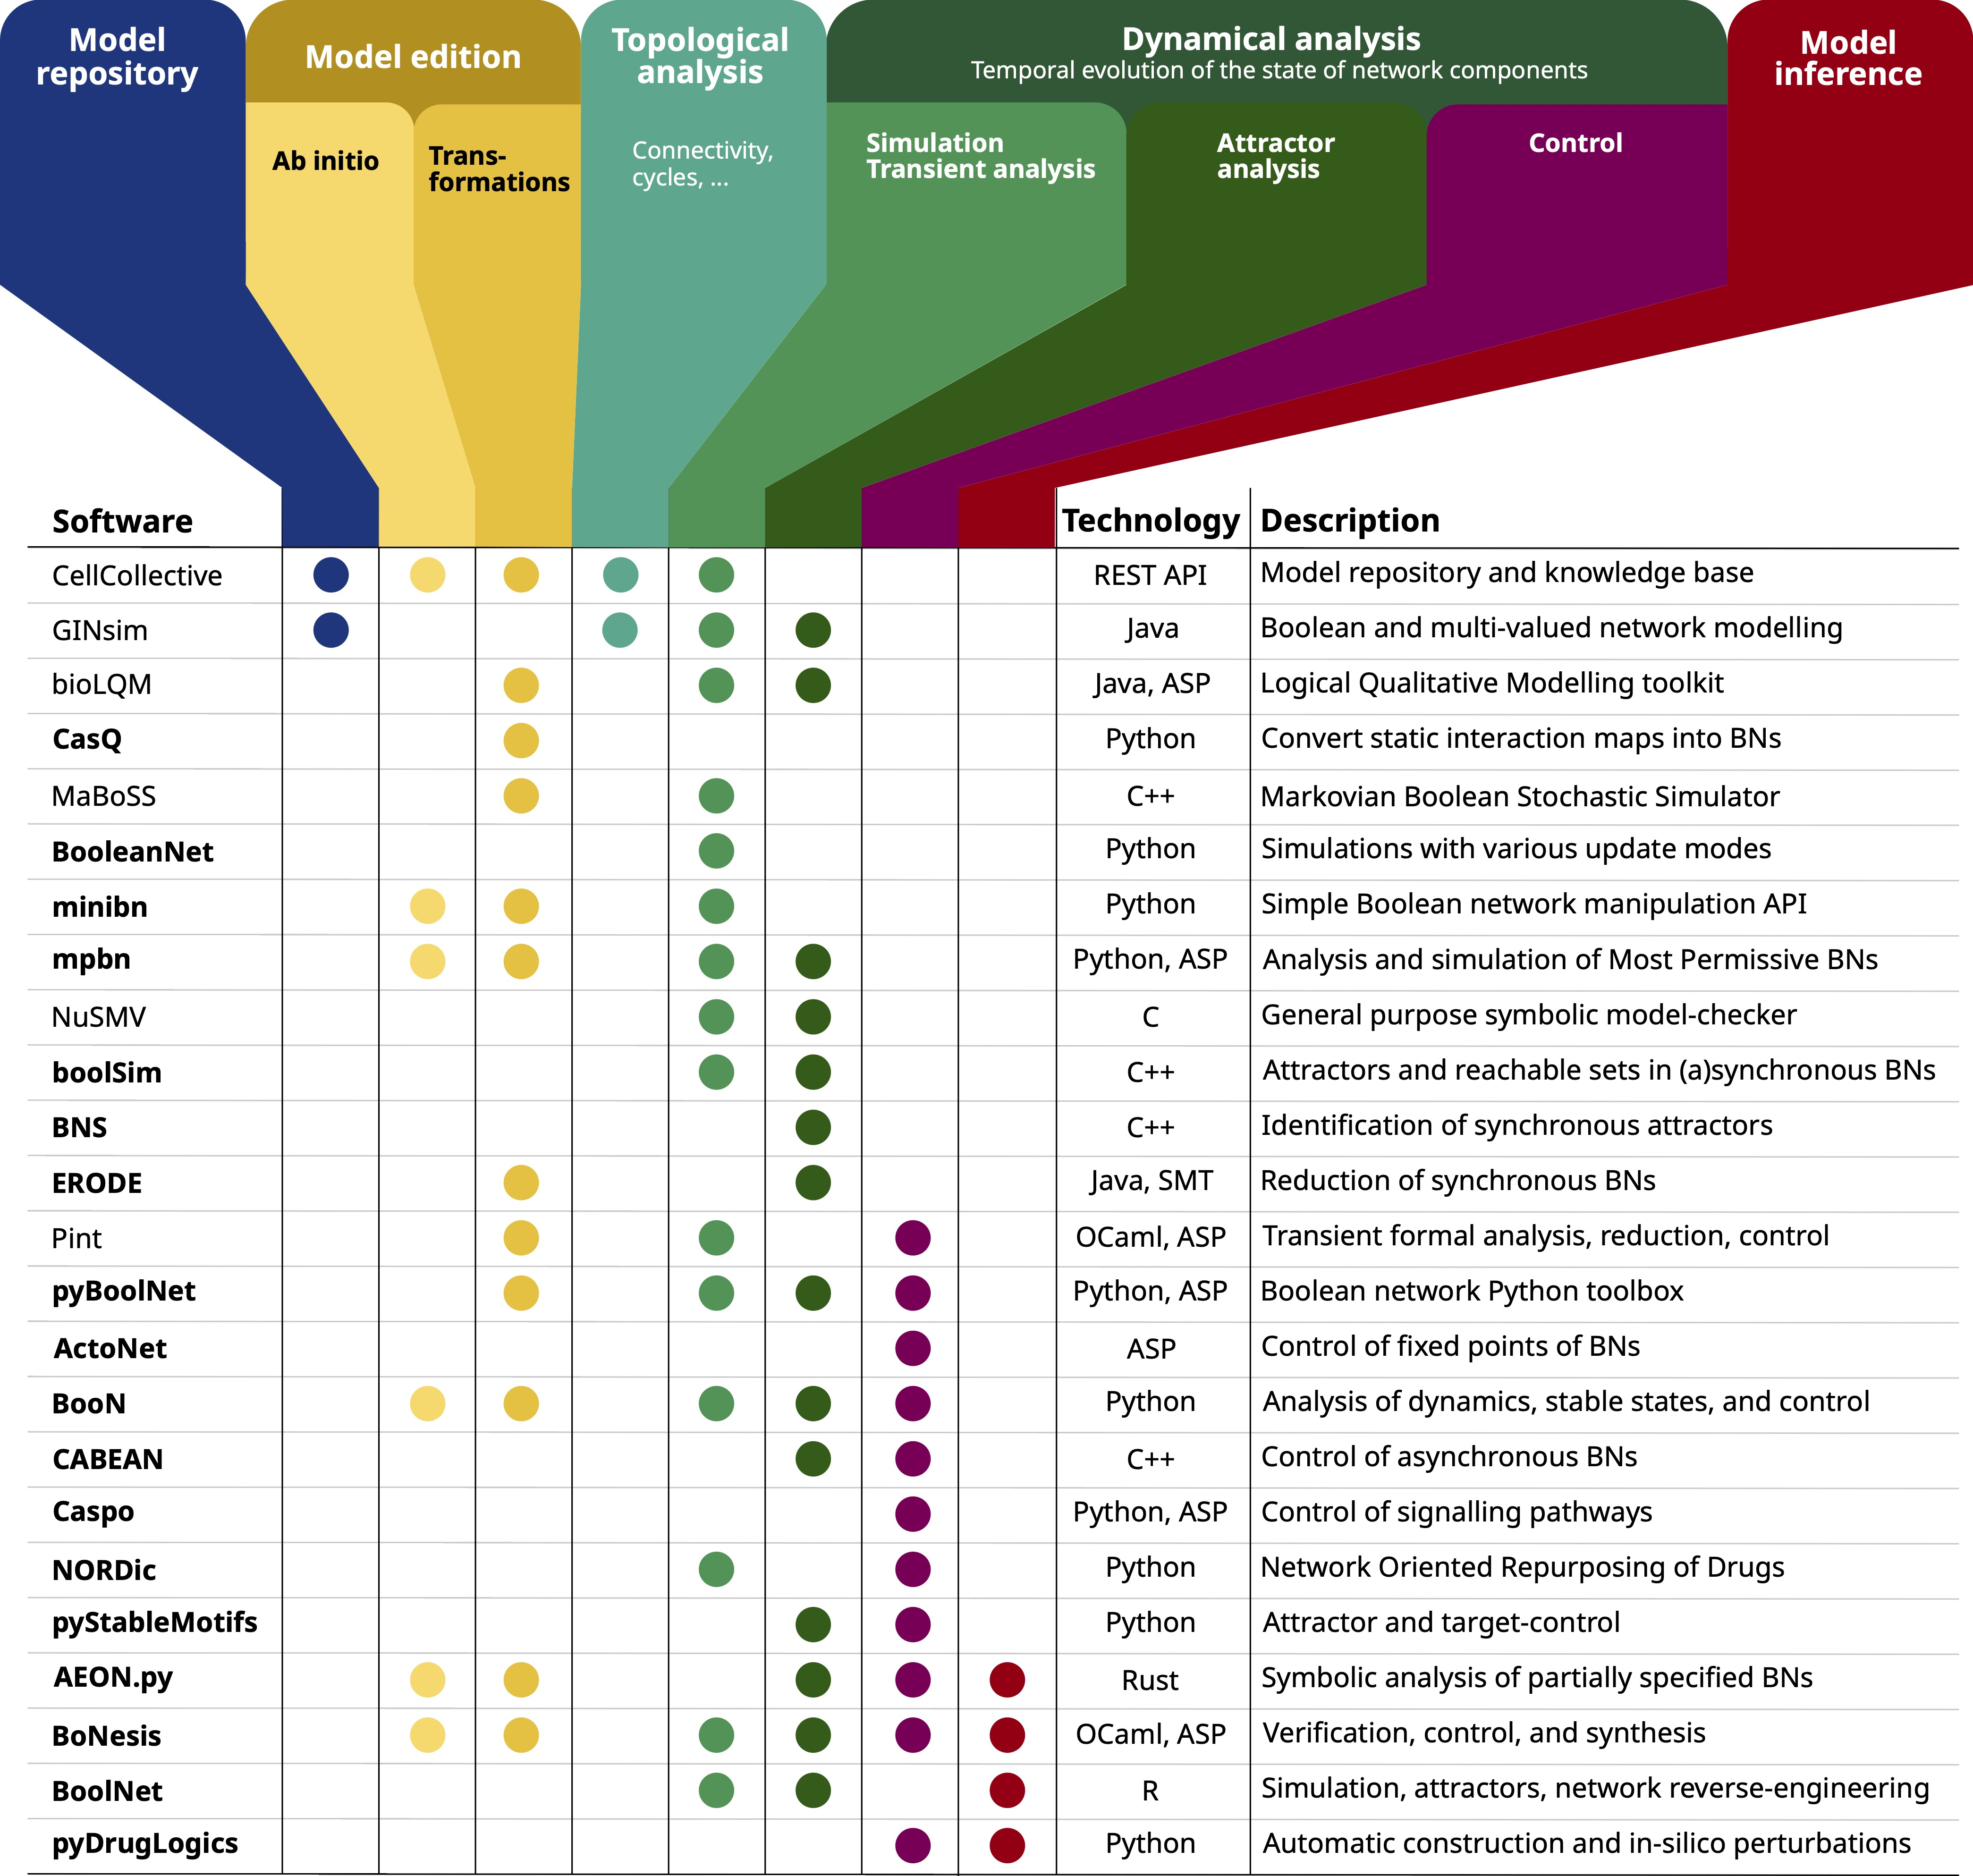

**Figure 1. Tools integrated in the CoLoMoTo suite.** Tools with names in bold have been added after the 2018 publication.

In this article, we propose an up-to-date tutorial to help users take advantage of the multiple tools integrated into the *CoLoMoTo* suite and perform sophisticated Boolean model analyses of complex signaling/regulatory networks. This tutorial relies on a comprehensive model of key signalling pathways and a core regulatory network controlling mammalian cell proliferation, published by Sizek et al. in 2019 [13].
As we shall see, the tutorial includes chunks of python code to reproduce several of the results and figures published in the original article and further extends these results with the help of several tools included in the *CoLoMoTo* suite. This tutorial specifically aims to demonstrate the added value of combining different tools to perform reproducible dynamic analyses.

## 2. Material and methods

## 2.1. Installation

This notebook can be run on a recent personal computer with at least 16 Go of RAM and about 10 Go of available disk space.
The *CoLoMoTo* environment can be installed either as a *Docker* container or as individual *conda* packages.

### 2.1.1.  Installation of the CoLoMoTo Docker container
Docker and Python need to be pre-installed, go to your folder and then type in a terminal:

```
pip install -U colomoto-docker
colomoto-docker -V 2025-01-01 --bind .
```

### 2.1.2. Installation of CoLoMoTo conda packages
As an alternative to using *Docker*, one can rely on *conda* to create a software environment able to reproduce the notebook on *Linux* and *macOS* computers with the following commands:
```
conda create -n sizek19 -c colomoto -c potassco -c conda-forge ginsim-python=0.4.5=py_0 bns-python=0.2=py_0 boolsim-python=0.5=py_0 pymaboss=0.8.9=py_0 notebook
conda activate sizek19
```

To launch this notebook, type the command:
```
jupyter notebook
```

## 2.2. Model
The model published by Sizek et al. [13] has been imported and edited with the *GINsim* software [14]. It is publicly available in the *zginml* format (including the layout, to be open with *GINsim*, version ≥ 3.0), as well as in the *sbml-qual* format, in the *GINsim* model repository (http://ginsim.org/). Hence, the model can be directly loaded from the notebook using the link to the corresponding *GINsim* model repository entry.  

Note that if you wish to work with this model offline, it can be downloaded locally and the loading command can be modified accordingly.

## 3. Model analysis

The following sections of notebook cover the following analyses:

* Loading of the packages required for the tutorial
* Loading of the model and visualisation of the network with *GINsim*.
* Attractor analysis with *bioLQM*.
* Computation of synchronous attractors with *BNS*.
* Analysis of the attractors of the model modules using *bioLQM*, *BNS* and *boolSim*.
* Stochastic simulations of the wild type model with *MaBoSS*.
* Stochatic dynamical simulations of mutants with *MaBoSS*.
* The construction of compressed probalistic transition graphs with *MaBoSS*.

### 3.1. Loading required packages
Before running the analyses, the packages to be used need to be loaded. For this tutorial, only the necessary CoLoMoTo packages are selected. 
The other packages listed in Figure 1 can be loaded according to the instructions provided at https://colomoto.github.io/colomoto-docker/.   
Note that these packages can also be loaded later on, just before their use.  

Pieces of code will be shown in this tutorial in boxes as follows. They represent code cells extracted from the python jupyter notebook. 

In [1]:
%%time
import numpy as np
import pandas as pd
import seaborn as sns
import ginsim 
import biolqm 
import maboss
import bns
import boolsim
import pyboolnet
from colomoto_jupyter import tabulate # for fixpoint table display
import matplotlib.pyplot as plt # for modifying plots
import os

This notebook has been executed using the docker image `colomoto/colomoto-docker:2025-01-01`

CPU times: user 1.25 s, sys: 293 ms, total: 1.54 s
Wall time: 2.72 s


### 3.2 Loading and Visualisation of the model with GINsim

We have used *bioLQM* [15] to import the model published by Sizek et al., and we updated the model layout with *GINsim*. The resulting model has the same logical rules as the original one and can be found in the *GINsim* repository at the address: http://ginsim.org/node/258

To load the model and visualise its regulatory graph, we run the following code cell:

In [2]:
# Loading and visualisation of the model
model_ginsim = ginsim.load("http://ginsim.org/sites/default/files/CellCycleControl_Sizek_PCB_2019.zginml")
ginsim.show(model_ginsim)

/notebook/CellCycleControl_Sizek_PCB_2019.zginml

This regulatory graph encompasses 87 components representing different molecular species and cellular processes involved in the regulation of cell proliferation and apoptosis in a generic human cell. The authors conceived this complex model as an association of six main functional modules:
- The growth signaling module (green nodes) incorporates growth signaling pathways driving cell cycle commitment, responsible for modeling the dynamics of PI3K, AKT1, MAPK, and mTORC.
- The restriction switch module (blue nodes): is responsible for commitment to DNA synthesis.
- The origin licensing switch module (yellow nodes) controls licensing and firing of replication origins.
- The phase switch module (pink nodes) controls cell cycle progression (G2 -> M -> G1), taking into account the role of Polo-like kinase 1 (Plk1) during mitosis.
- The apoptosis switch module (red nodes) implements the decision between cell survival versus apoptosis.
- The cellular processes module (orange nodes) includes nodes helping to identify the phenotypic state and covering additional regulatory mechanisms.

In the regulatory graph, green arrows denote activatory interactions, while red T arcs represent inhibitions. As many model components are regulated by multiple components, their behaviour in response to regulatory input levels is encoded in Boolean rules, which combine literals (i.e., node ids) with the classical Boolean operators NOT (written “!” in *GINsim*), OR (“|”), and AND (“&”).  The rules defined in the initial publication were encoded in the *zginml* file available in the *GINsim* model repository.

### 3.3. Attractor analysis with *bioLQM*

To obtain a first overview of the asymptotic properties of the model, we can use the software tool *bioLQM* [15], which includes an efficient algorithm to identify all stable states, regardless of their reachability [16].

We first need to convert our model in the biolqm format.

In [3]:
# conversion of the model for biolqm
model_biolqm = ginsim.to_biolqm(model_ginsim)

Using *bioLQM*, the stable states of the model can be computed in the following code cell.   
They correspond to long-term solutions of the model.

In [4]:
# Compute fixpoints
%time fps = biolqm.fixpoints(model_biolqm)
print(len(fps), "fixpoints") # shows the number of fixpoints
tabulate(fps) # table displaying all the fixpoints

CPU times: user 40.4 ms, sys: 19.7 ms, total: 60.1 ms
Wall time: 155 ms
8 fixpoints


GF  RTK  Grb2  Ras  RAF  mTORC2  PI3K  PIP3  PDK1  AKT_B  p110_H  PI3K_H  \
0   0    0     0    0    0       1     0     0     0      0       1       0   
1   0    0     0    0    0       1     0     0     0      0       1       0   
2   1    0     0    0    0       1     0     0     0      0       1       0   
3   1    0     0    0    0       1     0     0     0      0       1       0   
4   1    0     0    0    0       1     0     0     0      0       1       0   
5   1    0     0    0    0       1     0     0     0      0       1       0   
6   1    1     0    0    0       1     1     1     1      1       1       0   
7   1    1     0    0    0       1     1     1     1      1       1       0   

   AKT_H  FoxO3  PLCgamma  NeddL4  FoxO1  p21_mRNA  TSC2  PRAS40  Rheb  \
0      0      1         0       0      1         1     1       1     0   
1      0      1         0       0      1         1     1       1     0   
2      0      1         0       0      1         1     1       1     0   
3      0      1         0       0      1         1     1       1     0   
4      0      1         0       0      1         1     1       1     0   
5      0      1         0       0      1         1     1       1     0   
6      0      1         0       0      1         1     1       1     0   
7      0      1         0       0      1         1     1       1     0   

   mTORC1  S6K  eIF4E  GSK3  p21  pRB  p27Kip1  Myc  CyclinD1  E2F1  CyclinE  \
0       0    0      0     1    0    0        0    0         0     0        0   
1       0    0      0     1    0    0        0    0         0     0        0   
2       0    0      0     1    0    0        0    0         0     0        0   
3       0    0      0     1    0    0        0    0         0     0        0   
4       0    0      0     1    0    0        0    0         0     0        0   
5       0    0      0     1    0    0        0    0         0     0        0   
6       0    0      0     1    1    1        1    0         0     0        0   
7       0    0      0     1    1    1        1    0         0     0        0   

   ORC  Cdc6  Cdt1  Pre_RC  geminin  CyclinA_mRNA  Emi1  FoxM1  Cdc25A  \
0    0     0     0       0        0             0     1      0       0   
1    0     0     0       0        0             0     1      0       0   
2    0     0     0       0        0             0     1      0       0   
3    0     0     0       0        0             0     1      0       0   
4    0     0     0       0        0             0     1      0       0   
5    0     0     0       0        0             0     1      0       0   
6    0     0     0       0        0             0     0      0       0   
7    0     0     0       0        0             0     0      0       0   

   CyclinA  Wee1  UbcH10  CyclinB  Cdc25B  Plk1  Cdc25C  Cdk1  pAPC  Cdc20  \
0        0     0       0        0       0     0       0     0     0      0   
1        0     0       0        0       0     0       0     0     0      0   
2        0     0       0        0       0     0       0     0     0      0   
3        0     0       0        0       0     0       0     0     0      0   
4        0     0       0        0       0     0       0     0     0      0   
5        0     0       0        0       0     0       0     0     0      0   
6        0     0       0        0       0     0       0     0     0      0   
7        0     0       0        0       0     0       0     0     0      0   

   Cdh1  Replication  f4N_DNA  U_Kinetochores  Mad2  A_Kinetochores  Plk1_H  \
0     1            0        0               0     0               0       0   
1     1            0        0               0     0               0       0   
2     1            0        0               0     0               0       0   
3     1            0        0               0     0               0       0   
4     1            0        0               0     0               0       0   
5     1            0        0               0     0        

*bioLQM* returns eight *stable states* (also called *fixed points*), matching those reported by Sizek and colleagues in the Table S2 of their article.  

To better visualise any of these stable states, the corresponding values can be projected on the model regulatory graph with a simple code line, using *GINsim*. Such a visualisation highlights the pathways/modules that are active in one particular stable state. An example of such stable state projection is provided in the notebook.

In [5]:
# visualising the first fixed point from the table above.
ginsim.show(model_ginsim,fps[0])

Here we have projected the first stable stated reported in the table above. Inactivated nodes (value 0) are shown in white, while activated nodes (value 1) are shown in blue.

### 3.4. Computation of synchronous attractors with *BNS*
In their publication, Sizek et al. report the existence of a cyclic attractor when a synchronous updating method is used (i.e., when all components called to be updated by the Boolean rules at a given state are simultaneously updated, leading to a unique successor state). 

*BNS* can be used to compute the synchronous attractors of the model (i.e., fixed points and simple cyclic trajectories in the synchronous case). Although *BNS* can search for attractors of any length, this search fails with such a complex model. To overcome this limitation, a range of cycle lengths is defined and attractors for the corresponding lengths are explored sequentially.

As Sizek et al. reported a synchronous cycle of length 21 in their Table S2, we make sure to include this value in the interval considered.

Of note, an attractor of length k is also an attractor of length 2k, 3k, etc. In particular, fixed points are detected as attractors of any length. Hence, in the following code cell, we consider a maximum length of 32 and filter the attractors amounting to iterations of smaller ones.


In [6]:
# Code to compute synchronous attractors of lengths smaller or equal to a user-defined maximum length
def bns_attractors(model, max_length):
    bns_attractors = []
    for l in range(1,max_length):
        attractors = bns.attractors(model, length=l)
        count = len(attractors)

        # remove attractors which are already known
        for pl, pcount in bns_attractors:
            if l % pl == 0:
                count -= pcount
                if count < 1: break

        if count > 0:
            bns_attractors.append( (l,count) )
            print(f'The model has {count} synchronous cyclic attractors of length {l}')

In [7]:
%time bns_attractors(model_biolqm, 32)  # max-length is set to 32

The model has 8 synchronous cyclic attractors of length 1
The model has 4 synchronous cyclic attractors of length 10
The model has 1 synchronous cyclic attractors of length 21
CPU times: user 1.39 s, sys: 60.2 ms, total: 1.45 s
Wall time: 23.2 s


In addition to the eight fixed points already identified (corresponding to cyclic attractors of length 1), *BNS* returns four attractors of length 10, and one attractor of length 21, which correspond to the cyclic attractors reported by Sizek et al. in their supplementary Table S2.

Of note, attractors of lengths higher than 32 cannot be excluded by this analysis, as we use this number as a limit length to avoid long computations.


### 3.5. Analysis of the model constitutive modules.
To generate their complex model, Sizek and colleagues initially developed smaller models for different functional modules (cf. Introduction). These modules are provided by the authors in their supplementary material and we stored this information into a zip file available on *github*. The following code cell  retrieve this information and computes the total number of components, the number of other components regulating the components of the module (aka inputs), the number of stable states, the number of terminal trap spaces (comprising the stable states, but potentially also approximations to cyclic attractors), as well as the numbers of synchronous and asynchronous attractors for each of these modules.

In [8]:
# Download module files
if not os.path.isdir("Sizek_modules"):
    zf = "Sizek_modules.zip"
    if not os.path.exists(zf):
        print("Downloading", zf)
        from urllib.request import urlretrieve
        urlretrieve(f"https://gist.github.com/pauleve/6cbd2358e24086c15cfd2ecf5b2e35e7/raw/2750ef470c88a3d5044e3b4d76c2e4d31a84aa1b/{zf}",
                       filename=zf)
    print("Extracting", zf)
    from zipfile import ZipFile
    with ZipFile(zf, 'r') as z:
        z.extractall(".")

Extracting Sizek_modules.zip


In [9]:
def extract_module(full, name, m):
    cpts = [ n.getNodeID() for n in m.getComponents() ]
    mred = biolqm.submodel(full, " ".join(cpts))
    cpts = [ n.getNodeID() for n in mred.getComponents() ]
    biolqm.save(mred, "Sizek_modules/%s.mnet" % name)
    return mred

In [10]:
%%time
summary = {}
for f in os.listdir("Sizek_modules"):
    if f.endswith(".txt"):
        name = f[:-4]
        if name.startswith("full"): continue
        mdl = biolqm.load("Sizek_modules/%s.txt" % name, "booleannet")
        size = len( mdl.getComponents() )
        fps = biolqm.fixpoints(mdl, autoconvert=False)
        trp = biolqm.trapspaces(mdl, autoconvert=False)
        a_bns = bns.attractors(mdl)
        a_bsm = boolsim.attractors(mdl)
        mred = extract_module(model_biolqm, name, mdl)
        summary[name] = {
            "size": size,
            "inputs": mred.getComponents().size() - size,
            "fps": fps.size(),
            "traps": trp.size(),
            "sync": len(a_bns),
            "async": len(a_bsm)
        }
pd.DataFrame(summary)

CPU times: user 57 ms, sys: 1.2 ms, total: 58.2 ms
Wall time: 642 ms


Restriction_Switch  Apoptotic_Switch  PI3K  Phase_Switch  \
size                     7                16     8            15   
inputs                  14                13    11            16   
fps                      2                 2     0             3   
traps                    2                 2     1             3   
sync                     2                 2     1             3   
async                    2                 2     1             3   

        Origin_Licensing_Switch  
size                          4  
inputs                       11  
fps                           2  
traps                         2  
sync                          2  
async                         2

We can observe that the modules are highly interconnected, as they all have high numbers of inputs relative to their sizes, due to regulations exerted by nodes belonging to other modules.

Furthermore, all these modules but one display multistability but no cyclic behaviour. The PI3K module is the exception, as it has a unique, cyclic attractor, regardless of the use of synchronous or asynchronous updating. The cyclic behaviour of the PI3K module is indeed reported and discussed by Sizek et al.

At this point, it becomes apparent that the global cyclic behaviour corresponding to the cell cycle (see section 8) arises from the interconnections of multiple modules.

### 3.6 Characterisation of synchronous cyclic properties with bioLQM
To visualise the 21 states composing the synchronous cyclic attractor, *bioLQM* can be used to generate a trace from one of the cycle states reported by Sizek et al., considering a number of steps somewhat greater than 21. 

First, we define an initial state belonging to the cyclic attractor, according to Sizek et al. with the following code cell:

In [11]:
init_active = {'AKT_B',
 'BCL2',
 'BCLXL',
 'Cdc20',
 'Cdc25A',
 'Cdc25B',
 'Cdc25C',
 'Cdh1',
 'CyclinA_mRNA',
 'CyclinD1',
 'E2F1',
 'ERK',
 'Emi1',
 'GF',
 'GF_High',
 'Grb2',
 'IAPs',
 'MCL_1',
 'MEK',
 'Myc',
 'ORC',
 'PDK1',
 'PI3K',
 'PIP3',
 'Plk1_H',
 'RAF',
 'RTK',
 'Ras',
 'S6K',
 'SOS',
 'TSC2',
 'UbcH10',
 'eIF4E',
 'f4N_DNA',
 'mTORC1',
 'mTORC2',
 'pAPC'}

# dict-like representation, associating a node to either 0 or 1
init = {n: 1 if n in init_active else 0 for n in map(str, model_biolqm.getComponents())}
# str-like representation, for bioLQM
init_str = "".join(map(str, (init[n] for n in map(str, model_biolqm.getComponents()))))
init_str

'111111111100000000100111000011101000011010010101011101000100011100000000100000000110110'

Next, we compute a synchronous updating trace, starting with this initial state and considering a maximum of 50 steps, with the following code cell.

In [12]:
%%time
# The trace method of bioLQM typically takes the following arguments:
# -i - set of initial conditions specified for each node
# -m - maximum number of steps after which the simulation will stop
# -u - updating type (synchronous by default, can also be sequential where a certain updating order is prioritised)

trace = biolqm.trace(model_biolqm,f"-i {init_str} -m 50")
trace_df = pd.DataFrame( [s for s in trace] )
trace_df

CPU times: user 179 ms, sys: 19.9 ms, total: 199 ms
Wall time: 339 ms


GF  RTK  Grb2  Ras  RAF  mTORC2  PI3K  PIP3  PDK1  AKT_B  p110_H  PI3K_H  \
0    1    1     1    1    1       1     1     1     1      1       0       0   
1    1    1     1    1    1       1     1     1     1      1       0       0   
2    1    1     1    1    1       1     1     1     1      1       1       0   
3    1    1     1    1    1       1     1     1     1      1       1       1   
4    1    1     1    1    1       1     1     1     1      1       1       1   
5    1    1     1    1    1       1     1     1     1      1       1       1   
6    1    1     1    1    1       1     1     1     1      1       1       1   
7    1    1     1    1    1       1     1     1     1      1       1       1   
8    1    1     1    1    1       1     1     1     1      1       0       1   
9    1    1     1    1    1       1     1     1     1      1       0       0   
10   1    1     1    1    1       1     1     1     1      1       0       0   
11   1    1     1    1    1       1     1     1     1      1       0       0   
12   1    1     1    1    1       1     1     1     1      1       1       0   
13   1    1     1    1    1       1     1     1     1      1       1       1   
14   1    1     1    1    1       1     1     1     1      1       1       1   
15   1    1     1    1    1       1     1     1     1      1       1       1   
16   1    1     1    1    1       1     1     1     1      1       1       1   
17   1    1     1    1    1       1     1     1     1      1       1       1   
18   1    1     1    1    1       1     1     1     1      1       0       1   
19   1    1     1    1    1       1     1     1     1      1       0       0   
20   1    1     1    1    1       1     1     1     1      1       0       0   
21   1    1     1    1    1       1     1     1     1      1       0       0   

    AKT_H  FoxO3  PLCgamma  NeddL4  FoxO1  p21_mRNA  TSC2  PRAS40  Rheb  \
0       0      0         0       0      0         0     1       0     0   
1       0      1         0       0      1         0     1       0     0   
2       0      1         0       0      1         1     1       0     0   
3       0      1         0       0      1         1     1       0     0   
4       1      1         1       0      1         1     1       0     0   
5       1      0         1       0      0         1     0       0     0   
6       1      0         1       0      0         0     0       0     1   
7       1      0         1       1      0         0     0       0     1   
8       1      0         1       1      0         0     0       0     1   
9       0      0         0       1      0         0     0       0     1   
10      0      1         0       1      1         0     1       0     1   
11      0      1         0       0      1         1     1       0     0   
12      0      1         0       0      1         1     1       0     0   
13      0      1         0       0      1         1     1       1     0   
14      1      1         1       0      0         1     1       1     0   
15      1      0         1       0      0         0     0       0     0   
16      1      0         1       0      0         0     0       0     1   
17      1      0         1       1      0         0     0       0     1   
18      1      0         1       1      0         0     0       0     1   
19      0      0         0       1      0         0     0       0     1   
20      0      0         0       1      0         0     1       0     1   
21      0      0         0       0      0         0     1       0     0   

    mTORC1  S6K  eIF4E  GSK3  p21  pRB  p27Kip1  Myc  CyclinD1  E2F1  CyclinE  \
0        1    1      1     0    0    0        0    1         1     1        0   
1        1    1      1     0    0    0        0    1         1     1        0   
2        1    1      1     0    0    0        0    1         1     1        0   
3        1    1      1     0    1    0        0    1         1     1        0   
4        1    1      1     0    

The execution of this cell generates a table encompassing 22 rows (cf. notebook), each corresponding to one state belonging to a cyclic sequence. We can easily check that the first and last states listed in the table above are indeed identical with a few lines of python code.

In [13]:
first_row = trace_df.iloc[0]
last_row =  trace_df.iloc[-1]
if first_row.equals(last_row):
    print("The first state of the trace is equal to the last one")

The first state of the trace is equal to the last one


The execution of this cell confirms that we have identified the cyclic attractor of length 21 mentioned above. 

To ease the comparison of this sequence of states with the periodic pattern reported by Sizek et al. in their Figure 4, we can plot it with similar graphical conventions, using the following python code.

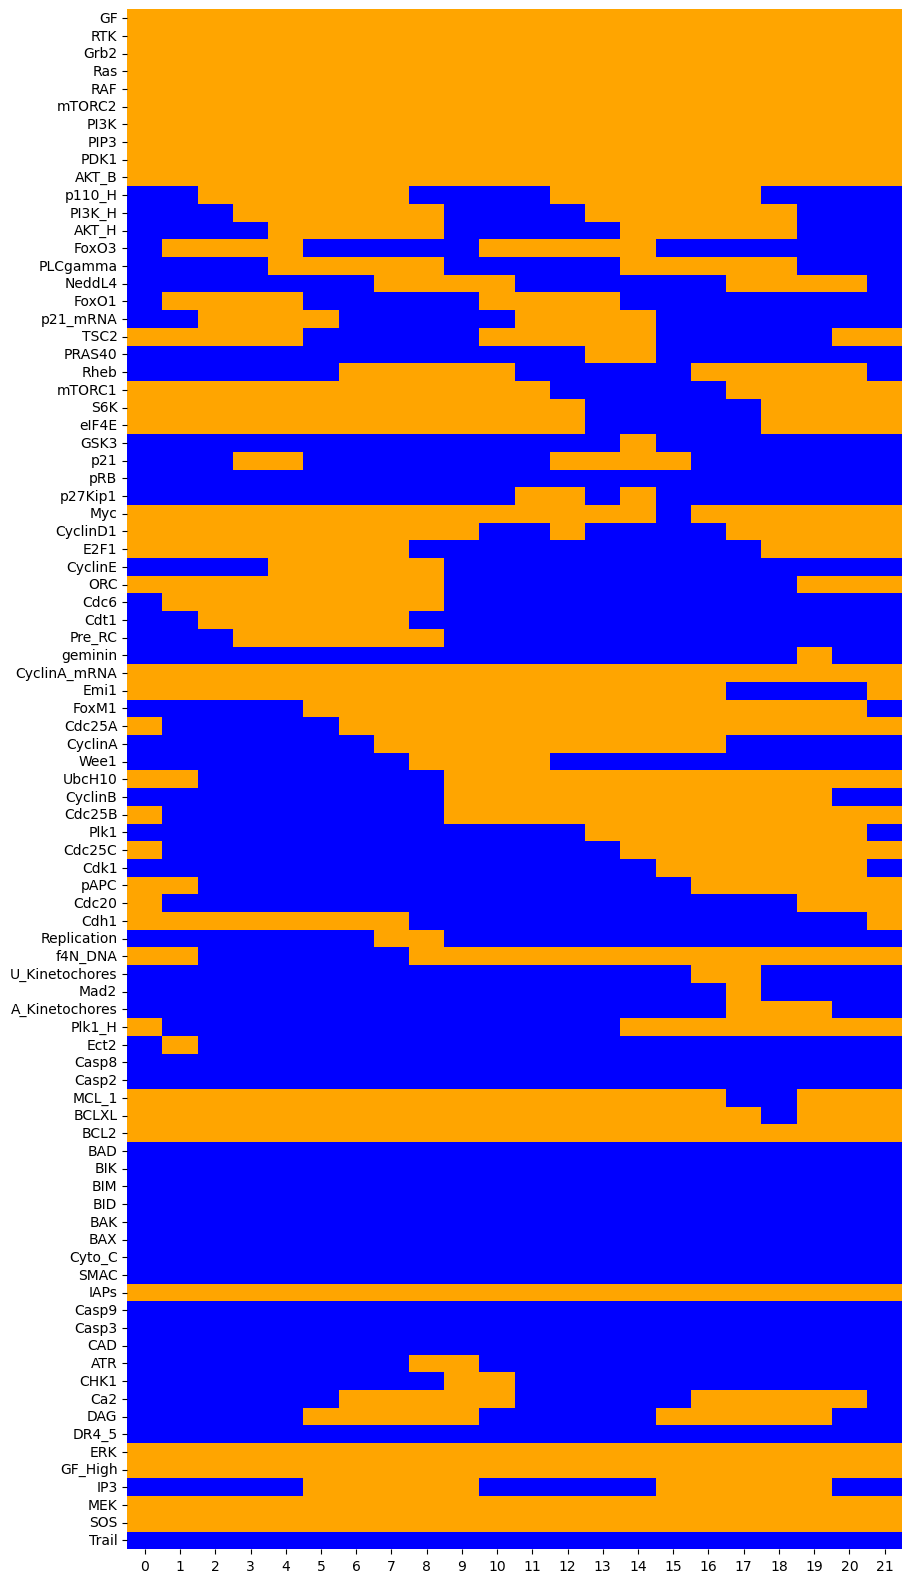

In [14]:
#Function used for plotting the dynamics of molecular species
def plotting(df):
    custom_cmap = sns.color_palette(['blue', 'orange'])
    fig = plt.figure(figsize=(10, 20))  # Adjust the figure size as needed
    sns.heatmap(df.T, cmap=custom_cmap, annot=False, cbar=False)
    plt.show()

plotting(trace_df)

This heat map displays a sequence of 22 states (columns) corresponding to the synchronous cycle of length 21, with the initial state (first column, index 0) matching the last one (column index 21). Orange cells denote active components (rows) at the corresponding cycle state (column), whereas blue cells denote suppressed components. Note that some nodes are never activated along the cycle, while others are always activated. In particular, the apoptotic pathway (BIM, BAX, BAK, CytC, Casp3, Casp9, etc.) is inactive in this sequence, while the cell cycle is activated by the MAPK pathway (RTK, Ras, Raf, PI3K, etc.).

Hence, using different tools, we could also identify the synchronous attractor reported by Sizek et al., which recapitulates the typical sequence of (in)activation of cell components, including cyclins. Further analysis of the timing of cyclins (in)activations is provided in section 11 below.

Of note, Sizek et al. reported that this cyclic behaviour is sensitive to the updating strategy used. To further characterise this sensitivity, *bioLQM* can be used to compute traces starting from the same initial state but using random asynchronous updating. This can be achieved using the following code cell.

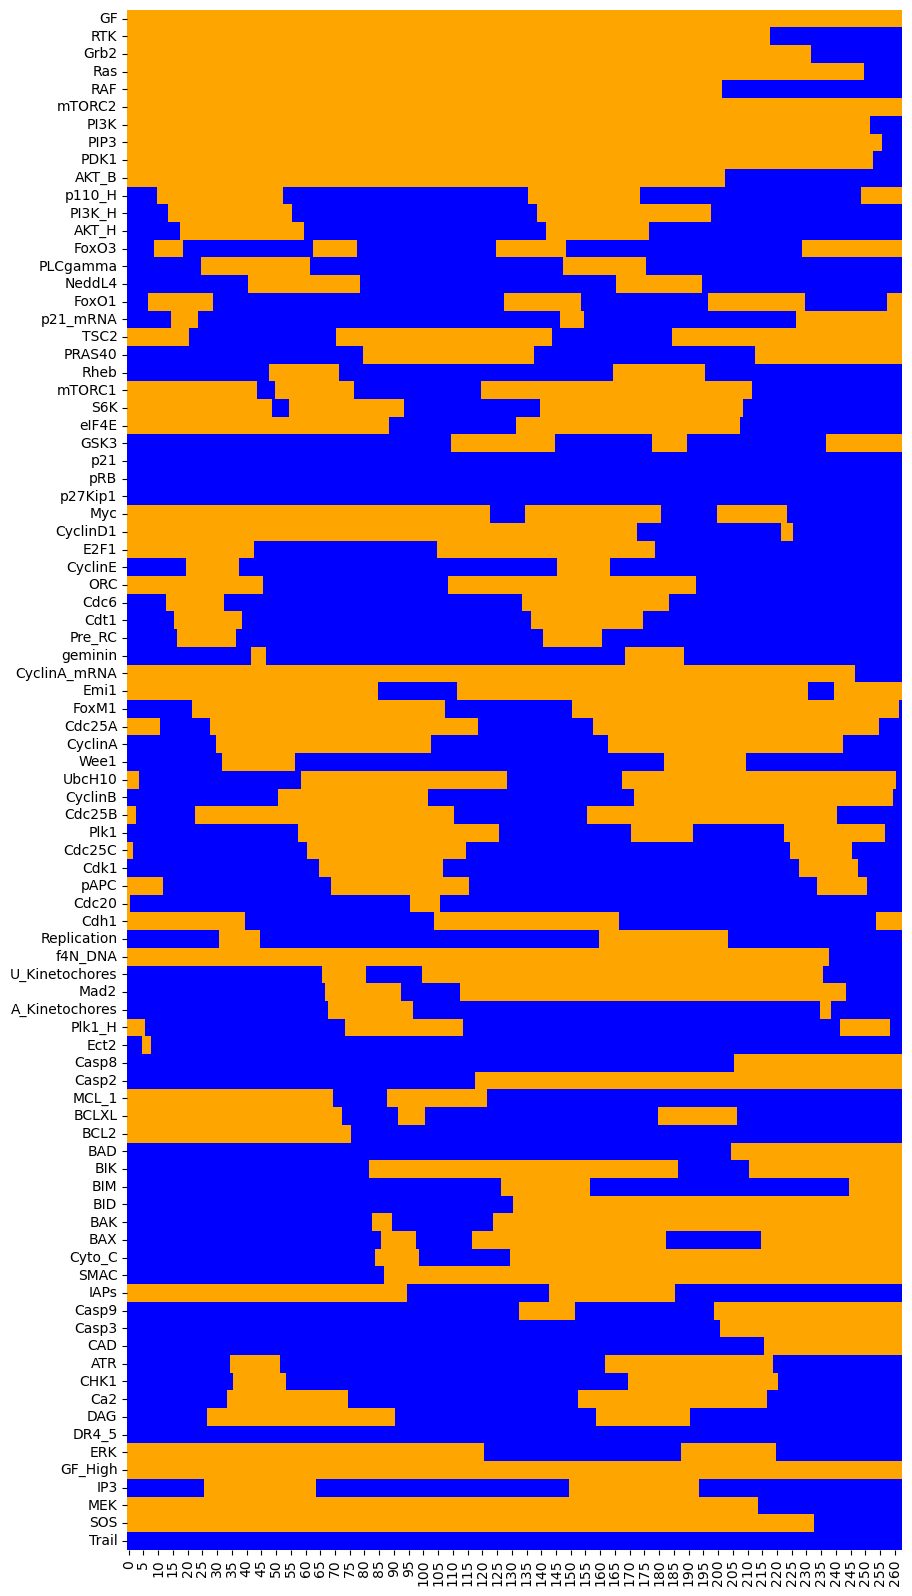

In [15]:
# Random asynchronous trace considering a maximum of 500 steps
random = biolqm.random(model_biolqm, f"-i {init_str} -m 500")
random_df = pd.DataFrame( [s for s in random] )
plotting(random_df)

Note that a longer maximal number of steps (500) is considered here because we do not know if the trace will end up in an asynchronous cycle, or how long such a cycle might be. 

In this heatmap, we can observe a quasi-periodic pattern, but this pattern gets progressively degraded along the simulation. This is due to the random choice of transitions whenever several components are called to switch their values at a given state, according to their logical rules. Of note, if we repeat the same random asynchronous simulation, we typically end up with a different quasi-periodic pattern. 

Interestingly, when bigger enough maximal step numbers are considered, simulations ultimately lead to a stable state corresponding to an apoptotic fate. To visualise this, in the notebook, we provide the code for a simulation using a maximum number of steps set to 2000, which needs to be uncommented to be run.

In [16]:
# %%time
# Random asynchronous trace considering a maximum of 2000 steps
# This high number is chosen in order to visualise the deriviation toward a stable state
# random = biolqm.random(model_biolqm, f"-i {init_str} -m 2000")
# random_df = pd.DataFrame( [s for s in random] )
# plotting(random_df)

In their manuscript, the authors defined a biased transition order to enforce a more robust cyclic behaviour. 

Hereafter, we propose an alternative approach to deepen our understanding of the asynchronous behaviour of the model, taking advantage of the software MaBoSS [17].

### 3.7. Using MaBoSS software to perform stochastic simulations of the wild type model

MaBoSS performs stochastic simulations over Boolean networks based on the continuous-time Markov chain formalism, relying on the Gillespie algorithm [17]. The software enables the generation of time plots showing the evolution of mean component values (or patterns thereof) and pie charts showing the probabilities of the different model states reached at the end of the simulation.

The biolqm model can be converted into the format required by MaBoSS using *bioLQM*.

In [17]:
# Conversion of bioLQM model into the MaBoSS format
model_maboss = biolqm.to_maboss(model_biolqm)

After loading the model, simulation parameters can be modified.

In [18]:
# Delineation of MaBoSS simulation parameters
model_maboss.update_parameters(sample_count=5000,max_time=200, time_tick=0.5)

This command line defines the following simulation parameters:
- Number of simulations: 5000.
- Maximum length of the simulation (in arbitrary unit): 200.
- Interval between two time points: 0.5.

These simulation parameters will be used for all the stochatic simulations reported in this notebook.

Next, we define a wild-type version of the model, called *WT*, and we select the *external variables*, i.e. the variables for which the values will be reported during the simulation. 
This is crucial to avoid combinatorial explosion.

In [19]:
WT = model_maboss.copy()
## Select outputs for visualization of the results
WT.network.set_output(('CyclinB','Casp3','PI3K_H','E2F1','Replication','p21', 'RTK'))

Note that when exporting a model to MaBoSS with bioLQM or GINsim, all the initial values are set to 0 by default.  
Hereafter, we assign to the model the initial conditions defined by Sizek et al. in their Figure 5.

In [20]:
# Define a state corresponding to Sizek’s initial condition
active_init = [ k for (k,v) in init.items() if v==1 ]
maboss.set_nodes_istate(WT, active_init, [0,1])

MaBoSS simulation results can be graphically displayed as *time plots* showing the probabilities of active nodes or model states (vectors of active nodes) over time, or as *pie charts* showing the probabilities of the final states (i.e., the states reached at the end of the simulations). 

In [21]:
%%time
# Run a MaBoSS simulation
run_WT = WT.run()

CPU times: user 2.55 ms, sys: 438 μs, total: 2.99 ms
Wall time: 49.1 s


Text(0.5, 1.0, 'Repartition of final WT model states')

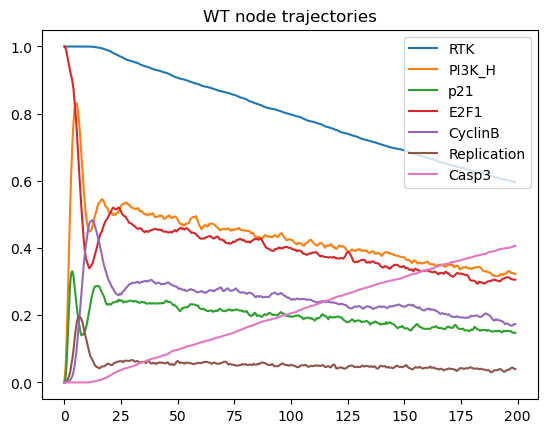

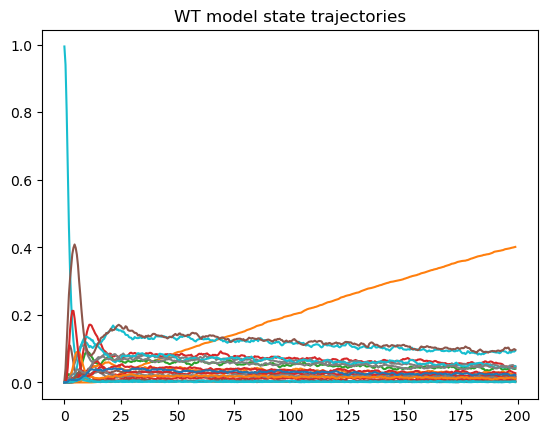

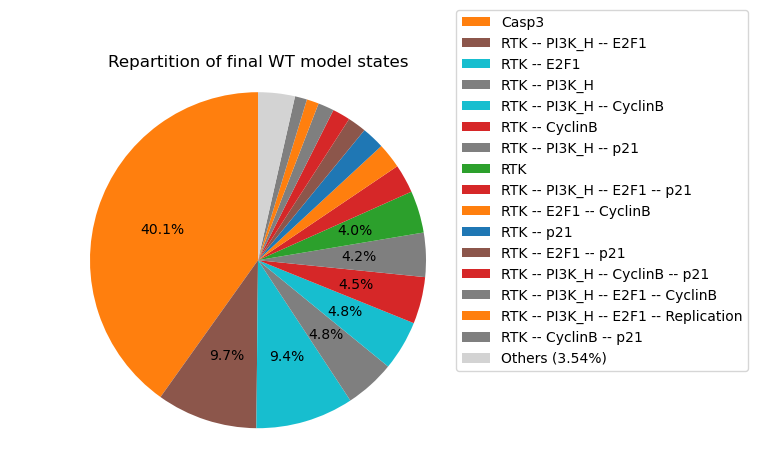

In [22]:
# Plot the trajectories of the WT simulation for selected nodes
run_WT.get_nodes_probtraj().plot(legend=True)
plt.title('WT node trajectories')
## Note that the model state <nil> means that none of the external variables are ON.

# Plot the trajectories of the WT simulation with model states
run_WT.plot_trajectory(legend=False)
plt.title('WT model state trajectories')

# Plot pie chart
run_WT.plot_piechart()
plt.title('Repartition of final WT model states')

The simulations reveal a transient cyclic-like behaviour, which is eventually lost due to the spontaneous Casp3 activation, thereby revealing the progressive dominance of the apoptotic stable state.

It is also  possible to plot the **state entropy** (H) and the **transition entropy** (TH) over time, which can be interpreted as signatures for the stable states or cyclic attractors.

Text(0.5, 1.0, 'WT entropy curves')

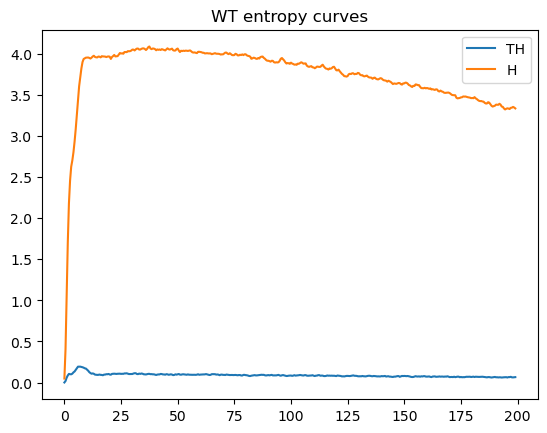

In [23]:
# Plot the state and transition entropy curves
run_WT.plot_entropy_trajectory()
plt.title('WT entropy curves')

The state entropy initially rises abruptly, and later slowly decreases.
In parallel, the transition entropy curve displays a little peak before remaining close to zero, with some noise.

Together, these two curves are suggestive of a quasi-periodic behaviour, which should collapse in the long term, as more and more cells trigger apoptosis.

Next, we can use *MaBoSS* to study the impact of changes in the initial conditions on the dynamic behaviour of the model. In the preceding simulation, all death signals were initially OFF. For example, we can assess the effect of activating TRAIL, keeping the rest of the other initial conditions unchanged.

The following code cells defines a copy of the WT model, triggers TRAIL level to 1 at the initial state, performs the simulation, and finally displays the results:

In [24]:
# Copy the WT model and change the value of Trail at the initial state
WT_death = WT.copy()
maboss.set_nodes_istate(WT_death, ["Trail" ] + active_init, [0,1])

In [25]:
%%time
# We repeat the MaBoSS simulations using the modified initial conditions.
# Run a MaBoSS simulation
WT_death.update_parameters(sample_count=5000,max_time=200, time_tick=0.5)
run_WT_death = WT_death.run()

CPU times: user 2.32 ms, sys: 374 μs, total: 2.69 ms
Wall time: 14.2 s


Text(0.5, 1.0, 'Entropy curves for WT model with dead signal ON')

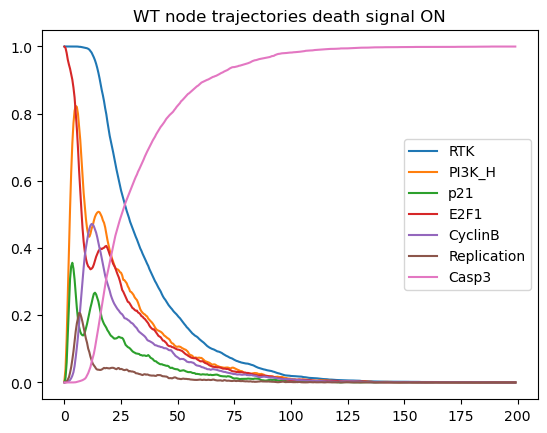

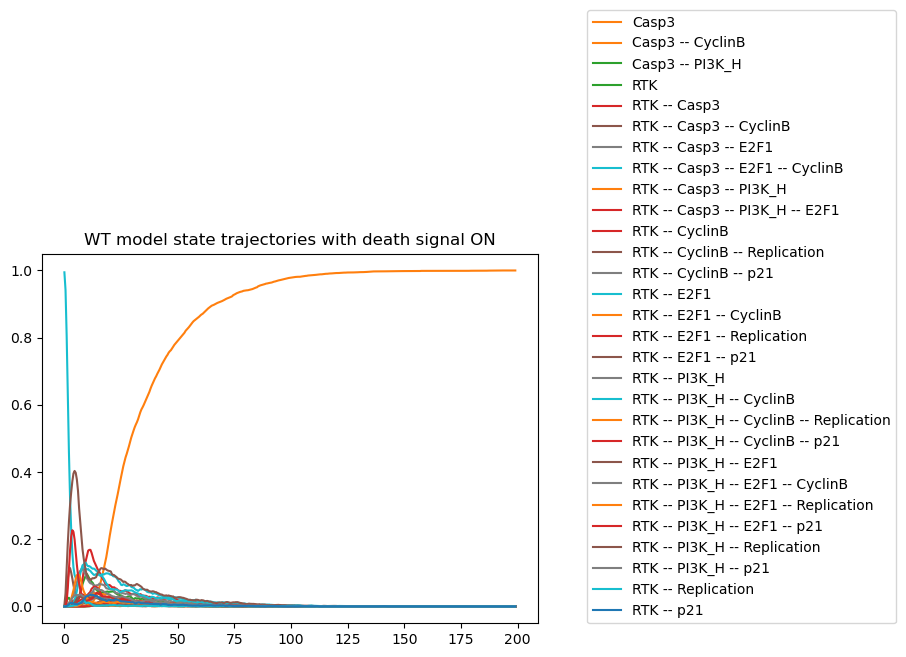

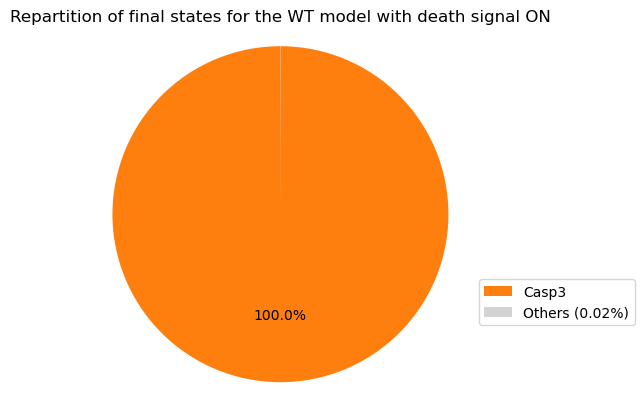

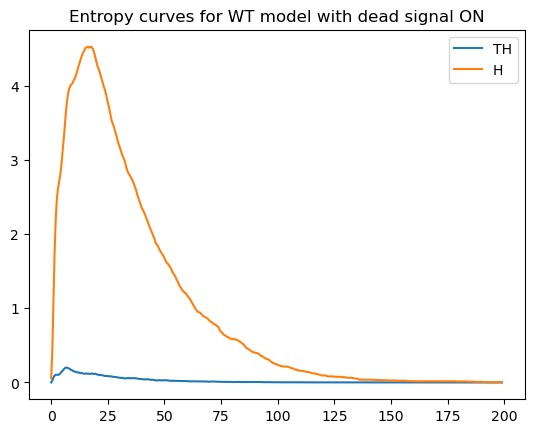

In [26]:
# Plot the results for the WT model with dead signal ON
# Plot the WT node trajectories with dead signal ON
#run_WT_death.plot_trajectory(legend=False)
run_WT_death.get_nodes_probtraj().plot(legend=True)
plt.title('WT node trajectories death signal ON')
# Plot the WT model state trajectories with dead signal ON
run_WT_death.plot_trajectory(legend=True)
plt.title('WT model state trajectories with death signal ON')
# Plot WT pie chart with dead signal ON
run_WT_death.plot_piechart(legend=True)
plt.title('Repartition of final states for the WT model with death signal ON')
# Plot the WT state and transition entropy curves with dead signal ON
run_WT_death.plot_entropy_trajectory()
plt.title('Entropy curves for WT model with dead signal ON')

The activation of Trail at the initial state enables a faster rise of Casp3 and thus of the apoptotic fate. In parallel, the state entropy drops much faster, while the transition entropy stabilises around zero, suggesting a stable state situation.

### 3.8. Mutant simulations with MaBoSS


In their article, Sizek and colleagues report a sophisticated analysis of the role and dynamical properties of the PI3K/AKT1 pathway, and recapitulate deleterious effects of its alterations. They further analyse the impact of the blocking of the Polo-like kinase 1 (Plk1, a mitotic driver and chemotherapy target) on cell cycle progression. 

Hereafter, we focus on the analysis of the impact of the perturbation of other model components, using the *MaBoSS* software.

#### 3.8.1. Stochastic simulation of Casp8 ectopic activity

We first simulate the impact of a Casp8 ectopic activity and display the resulting time plot and pie chart.

In [27]:
%%time
# MaBoSS simulation for Casp8 ectopic activity
mut_Casp8_ON = WT.copy()
mut_Casp8_ON.mutate("Casp8", "ON")
mutres_Casp8_ON = mut_Casp8_ON.run()

CPU times: user 3.55 ms, sys: 539 μs, total: 4.09 ms
Wall time: 13.8 s


Text(0.5, 1.0, 'Repartition of final model states for Casp8 ectopic activity')

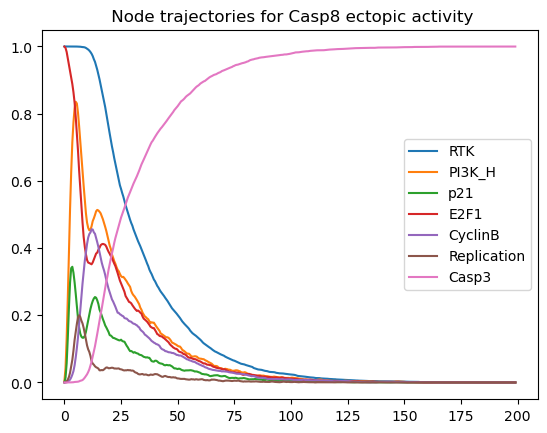

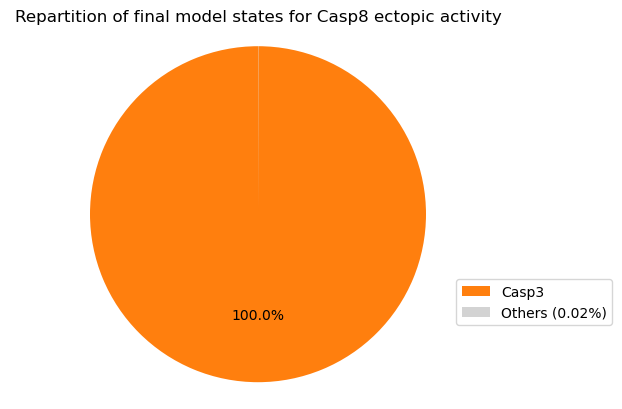

In [28]:
# Plot the time plot and pie chart for Casp8 ectopic activity
mutres_Casp8_ON.get_nodes_probtraj().plot(legend=True)
plt.title(' Node trajectories for Casp8 ectopic activity')
mutres_Casp8_ON.plot_piechart()
plt.title('Repartition of final model states for Casp8 ectopic activity')

Based on these results, we can conclude that the ectopic expression of Casp8 drives the cells into apoptosis faster, no matter if TRAIL is ON or OFF.

#### 3.8.2. Stochastic simulation of Casp8 knockdown

We can also check the impact of a full knockdown of Casp8.

In [29]:
%%time
# MaBoSS simulation for Casp8 knockdown
mut_CASP8_OFF = WT.copy()
mut_CASP8_OFF.mutate("Casp8", "OFF")
mutres_CASP8_OFF = mut_CASP8_OFF.run()

CPU times: user 4.54 ms, sys: 674 μs, total: 5.21 ms
Wall time: 49.5 s


Text(0.5, 1.0, 'Repartition of final states for the CASP8 knockdown model')

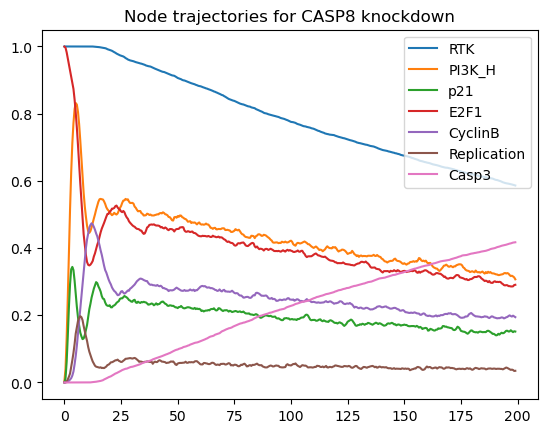

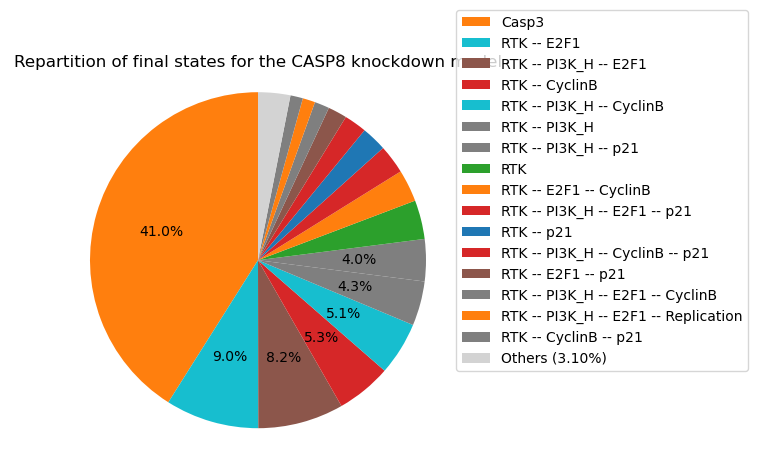

In [30]:
## Plot the trajectories of the model states
# mutres_CASP8_OFF.plot_trajectory(legend=True)
# plt.title('Model state trajectories for CASP8 knockdown')

# #Plot the time plot and pie chart for Casp8 ectopic activity
mutres_CASP8_OFF.get_nodes_probtraj().plot(legend=True)
plt.title('Node trajectories for CASP8 knockdown')
mutres_CASP8_OFF.plot_piechart(legend=True)
plt.title('Repartition of final states for the CASP8 knockdown model')

Casp3 is initially blocked but becomes ultimately activated, like in the wild-type case, independently of the status of Casp8. Hence, the model predicts that apoptosis should ultimately occur even in the absence of Casp8 activity. The knockout of Casp8 does not affect the model in the absence or presence of TRAIL.

Of note, it is possible to knock out a specific interaction with bioLQM, using the syntax: ```target:regulator%0```, denoting a blockade of the interaction exerted by the regulator onto the target. Below, we provide the code to perform the simulation of such an edgetic perturbation blocking the regulation of Casp3 by Casp8. This code cell must be uncommented before execution.

In [31]:
# m_perturbed = biolqm.perturbation(model_biolqm, "Casp3:Casp8%0")

## Translation of the edgetic variant model into MaBoSS format
#perturbed_maboss = biolqm.to_maboss(model_biolqm)

## Specification of simulation parameters and selection of output nodes
#perturbed_maboss.update_parameters(sample_count=5000,max_time=200, time_tick=0.5)
#perturbed_maboss.network.set_output(('CyclinB','FoxO3', 'Casp8', 'GSK3','BIM', 'BCL2', 'Casp3'))

## Definition of the intitial state, according to Fig. 5 of Sizek et al (2019).
#active_init = [ k for (k,v) in init.items() if v==1 ]
#maboss.set_nodes_istate(perturbed_maboss, active_init, [0,1])

## Run a MaBoSS simulation
#run_perturbed_maboss = perturbed_maboss.run()

## Plot the trajectories of selected nodes
#run_perturbed_maboss.get_nodes_probtraj().plot(legend=True)
#plt.title('MaBoSS simulation of Casp3:Casp8%0 model variant')

However, the simulation of this edgetic mutant does not bring any new insight into the behaviour of the model under consideration.

#### 3.8.3. Multiple mutant simulations
We further provide example code to systematically explore a series of mutants, and to filter the results corresponding to a blockade of apoptosis (denoted by the suppression of Casp3 activation) while conserving a cycling activity (denoted here by an average CyclinE activity > 15%). As we hereby consider ten mutant simulations (two for each of the five nodes in list_mutant, for inhibition and activation), the execution of this cell can take about one hour on a good laptop.

In [32]:
from maboss.pipelines import simulate_single_mutants, filter_sensitivity
list_mutants = ["PI3K_H", "p110_H", "p21", "Plk1", "FoxO3"]
explore_mutants = WT.copy()
explore_mutants.network.set_output(["Casp3", "CyclinA", "CyclinB", "CyclinE"])

CPU times: user 161 ms, sys: 8.68 ms, total: 169 ms
Wall time: 4min 39s


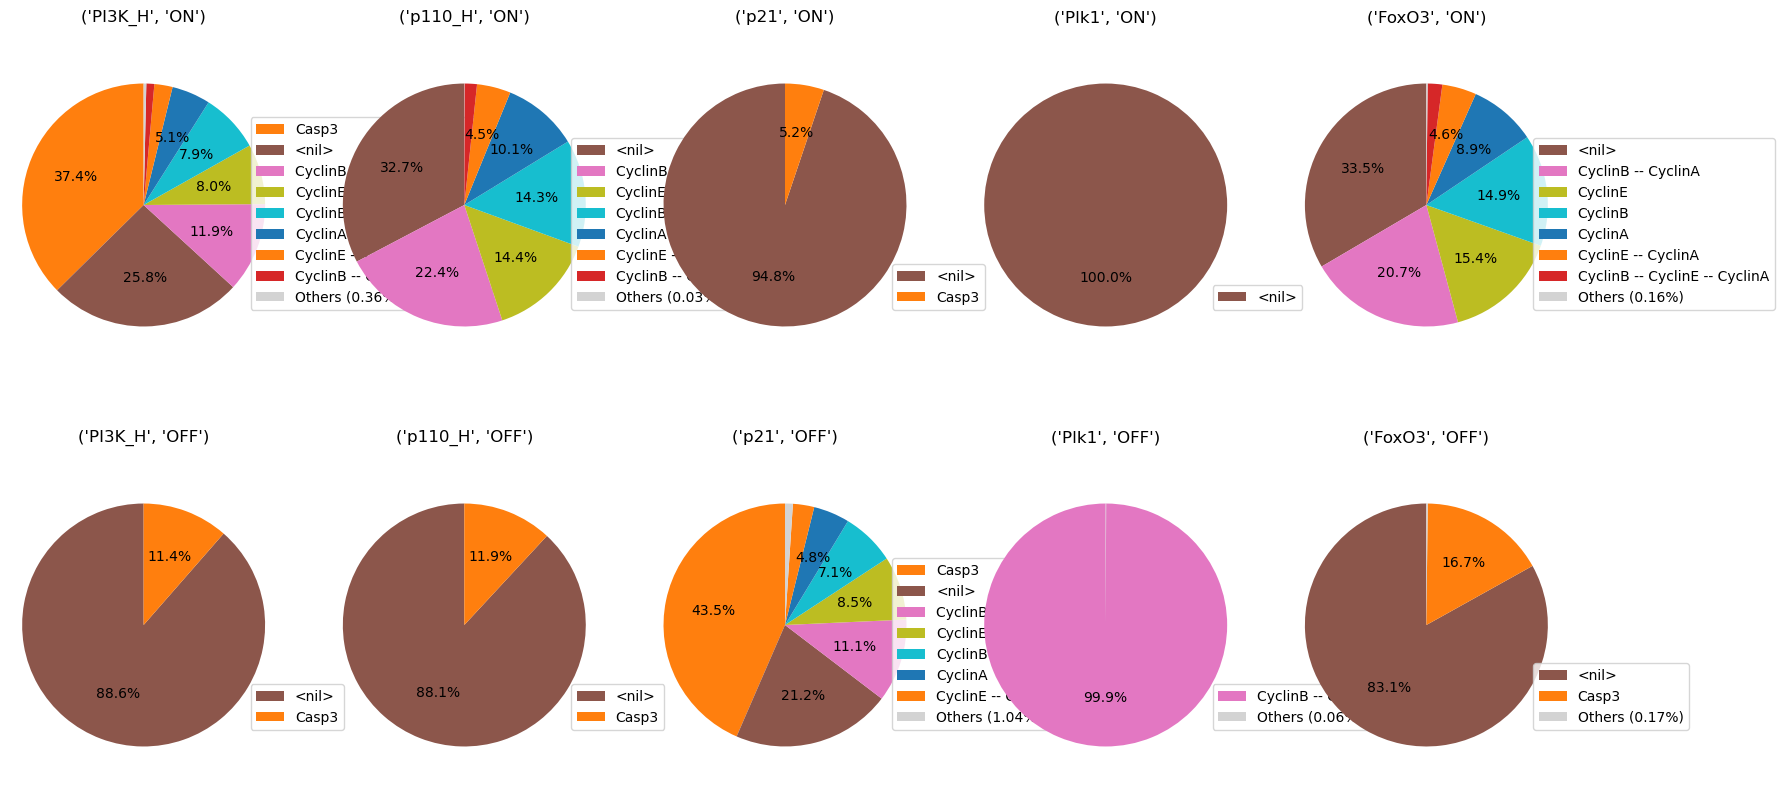

In [33]:
%%time
results = simulate_single_mutants(explore_mutants, list_mutants, sign='BOTH')
fig, ax = plt.subplots(2,5,figsize=(20,10))

for i, (name, result) in enumerate(results.items()):
    axes = ax[(i//5), (i%5)]
    result.plot_piechart(axes=axes)
    axes.set_title(name)

/opt/conda/lib/python3.11/site-packages/maboss/figures.py:59: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper right')


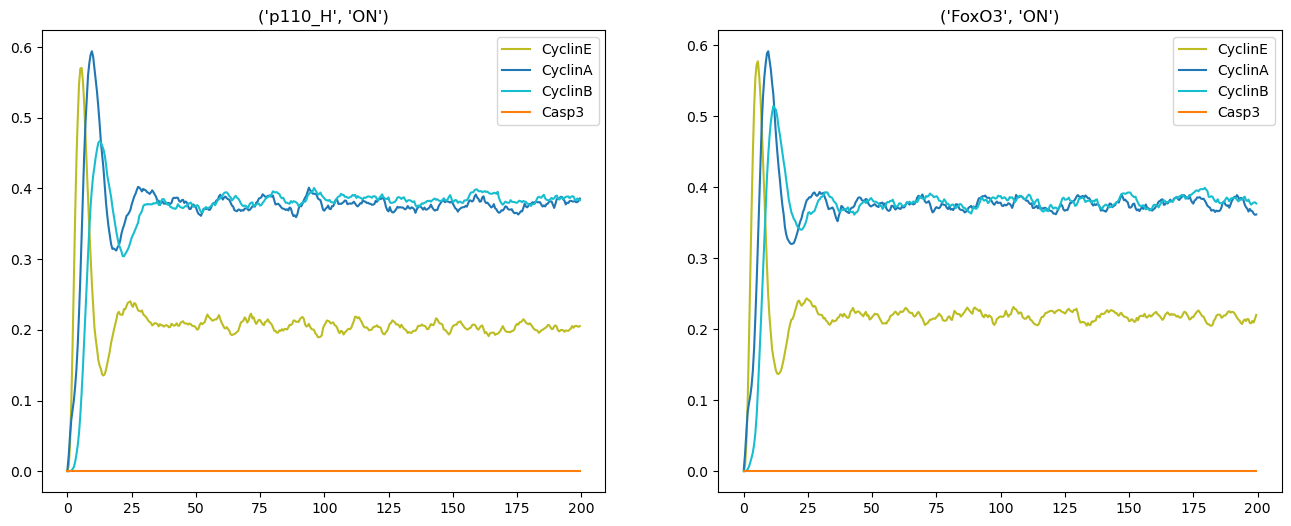

In [34]:
filtered_results = filter_sensitivity(results, node='Casp3', maximum=0.01)
filtered_results = filter_sensitivity(filtered_results, node='CyclinE', minimum=0.15)

fig, ax = plt.subplots(1,len(filtered_results),figsize=(16,6))

for i, (name, result) in enumerate(filtered_results.items()):
    axes = ax[i]
    result.plot_node_trajectory(axes=axes)
    axes.set_title(name)

From this analysis, we can conclude that both p110 and FoxO3 sustained activations are able to turn off Casp3 activity, while maintaining the cycle. Note that we don't use a complete absence of Casp3 activity here (0%) as a filter but instead a quasi absence of activity (1%), as a very small activity might persist. 

### 3.9. Deeper analysis of the quasi-cyclic synchronous attractor

In this section, we explore the dynamics of the cell cycle by studying the succession of cyclin activations and inactivations. In the WT situation, we expect that the cyclins get activated in the following order: CyclinE, followed by CyclinA, then CyclinB, and that they get inactivated as follows: Cyclin E is inactivated, then CyclinA, and finally CyclinB. 

#### 3.9.1. Verification of the order of activations of cyclins in the WT situation by plotting a compressed state transition graph

The following code cells defines a simulation of the WT model focusing on cyclin dynamics.

CPU times: user 0 ns, sys: 4.14 ms, total: 4.14 ms
Wall time: 49.5 s


Text(0.5, 1.0, 'WT cyclins trajectories')

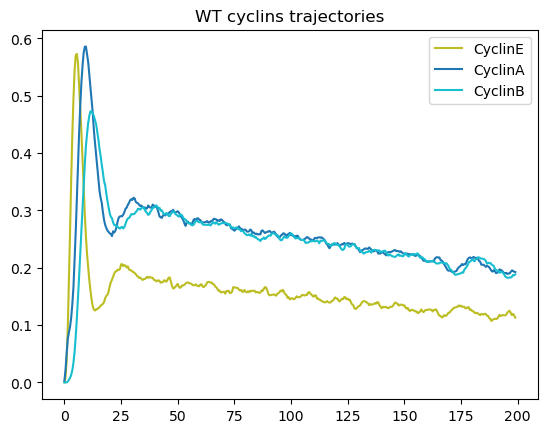

In [35]:
outputs = ["CyclinA", "CyclinB", "CyclinE"]
WT.network.set_output(outputs)
%time res = WT.run()
res.plot_node_trajectory()
plt.title('WT cyclins trajectories')

We can see that the cyclins follow the expected order. Note that as MaBoSS reports mean probabilities over time, these oscillations are rapidly damped.

We can further compute the frequencies of cyclin activations and inactivations over all individual trajectories of the simulation. To do this, we use a new functionality of MaBoSS estimating the frequencies of transitions between activity patterns involving selected nodes and plot them as a graph. To prevent explosion of the size of this graph, we only use the three main cyclins responsible for the cyclic attractor. The following code cells compute such transition frequencies and display the results as a compressed state transition graph, i.e. a projection of the transition frequencies computed over the full state space onto the cyclin activity patterns of interest.

In [36]:
WT_trajs = WT.copy()
WT_trajs.network.set_observed_graph_nodes(["CyclinA", "CyclinB", "CyclinE"])

In [37]:
%time res_trajs = WT_trajs.run()

CPU times: user 3.28 ms, sys: 438 μs, total: 3.72 ms
Wall time: 48.5 s


In [38]:
res_trajs.get_observed_graph() 

<nil>   CyclinB   CyclinE  \
State                                                         
<nil>                          0.000000  0.020829  0.800209   
CyclinB                        0.981235  0.000000  0.000000   
CyclinE                        0.128798  0.000000  0.000000   
CyclinB -- CyclinE             0.000000  0.589912  0.267544   
CyclinA                        0.476201  0.000000  0.000000   
CyclinB -- CyclinA             0.000000  0.834320  0.000000   
CyclinE -- CyclinA             0.000000  0.000000  0.003425   
CyclinB -- CyclinE -- CyclinA  0.000000  0.000000  0.000000   

                               CyclinB -- CyclinE   CyclinA  \
State                                                         
<nil>                                    0.000000  0.178962   
CyclinB                                  0.004959  0.000000   
CyclinE                                  0.002414  0.000000   
CyclinB -- CyclinE                       0.000000  0.000000   
CyclinA                                  0.000000  0.000000   
CyclinB -- CyclinA                       0.000000  0.163925   
CyclinE -- CyclinA                       0.000000  0.642621   
CyclinB -- CyclinE -- CyclinA            0.020152  0.000000   

                               CyclinB -- CyclinA  CyclinE -- CyclinA  \
State                                                                   
<nil>                                    0.000000            0.000000   
CyclinB                                  0.013806            0.000000   
CyclinE                                  0.000000            0.868788   
CyclinB -- CyclinE                       0.000000            0.000000   
CyclinA                                  0.507721            0.016077   
CyclinB -- CyclinA                       0.000000            0.000000   
CyclinE -- CyclinA                       0.000000            0.000000   
CyclinB -- CyclinE -- CyclinA            0.977506            0.002341   

                               CyclinB -- CyclinE -- CyclinA  
State                                                         
<nil>                                               0.000000  
CyclinB                                             0.000000  
CyclinE                                             0.000000  
CyclinB -- CyclinE                                  0.142544  
CyclinA                                             0.000000  
CyclinB -- CyclinA                                  0.001755  
CyclinE -- CyclinA                                  0.353954  
CyclinB -- CyclinE -- CyclinA                       0.000000

Text(0.5, 1.0, 'WT Compressed state transition graph of cyclins')

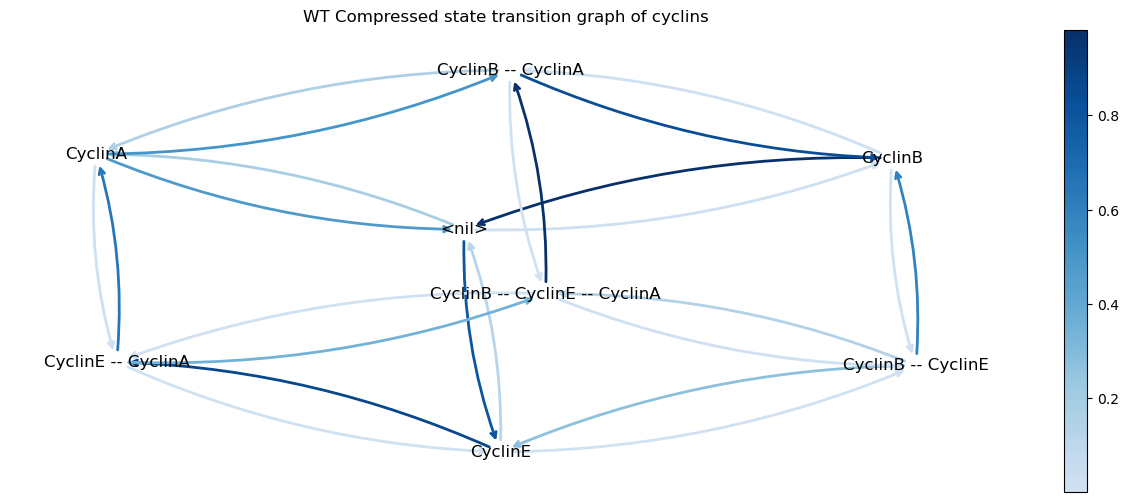

In [39]:
fig, ax = plt.subplots(1,1,figsize=(16,6))
res_trajs.plot_observed_graph(axes=ax)
plt.title('WT Compressed state transition graph of cyclins')

In this graph, the transitions denoted by darker blue arrows have a higher probability of occurring. This representation enables us to visualise the most probable sequence of cyclin activations and inactivations. Starting from the state (corresponding to G0), the most probable sequence of state transitions successively involves CyclinE activation, CyclinA activation, CyclinE inactivation, CyclinB activation, CyclinA inactivation, and finally CyclinB inactivation, thereby completing the cycle. Note that other cycles can be followed with lower probabilities.

#### 3.9.2. Analysis of the apoptosis triggering timing along the cell cycle

Here we study the condition leading to apoptotic death, focusing on the point in the cell cycle where Casp3 is activated.

In [40]:
outputs =["Casp3", "CyclinA", "CyclinB", "CyclinE"]
WT.network.set_output(outputs)
WT.network.set_observed_graph_nodes(outputs)

CPU times: user 0 ns, sys: 3.46 ms, total: 3.46 ms
Wall time: 47 s


Text(0.5, 1.0, 'WT cyclins and Casp3 trajectories')

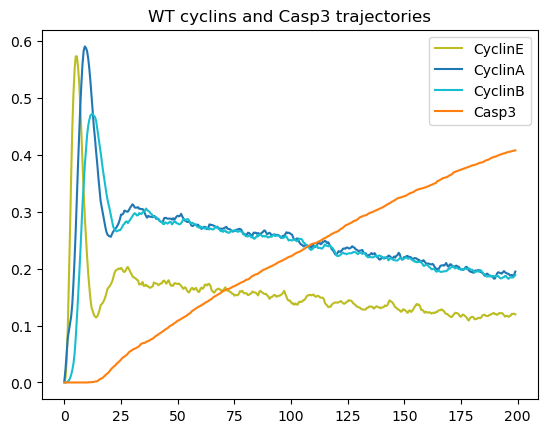

In [41]:
%time res = WT.run()
res.plot_node_trajectory()
plt.title('WT cyclins and Casp3 trajectories')

we can observe that cells initially follow the expected cycle, but quickly activate Casp3 and are thus led to apoptosis.

Text(0.5, 1.0, 'WT Compressed state transition graph of cyclins and Casp3')

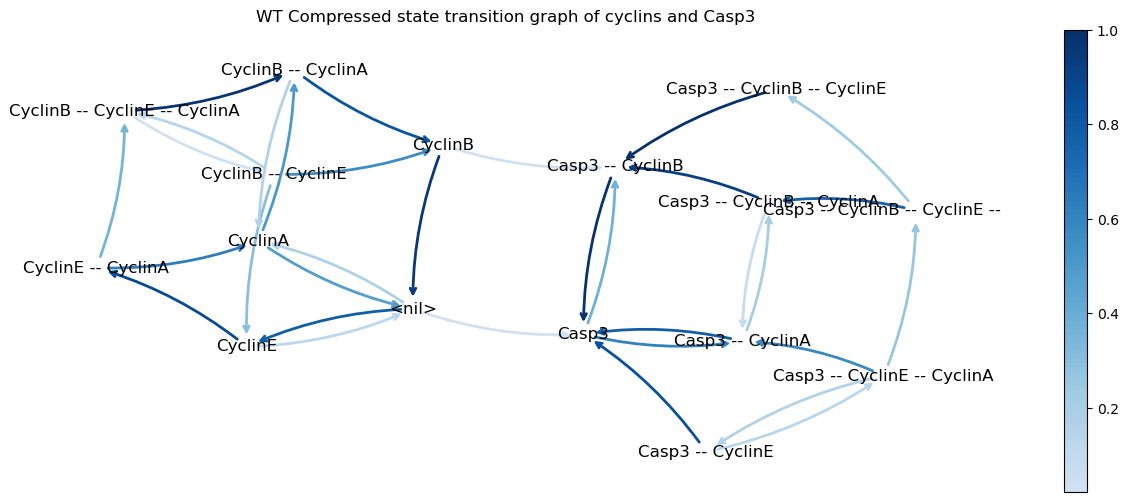

In [42]:
fig, ax = plt.subplots(1,1,figsize=(16,6))
res.plot_observed_graph(axes=ax, prob_cutoff=0.02)
plt.title('WT Compressed state transition graph of cyclins and Casp3')

Note that we used a minimum probability threshold to avoid plotting unlikely edges. We see that there are two main ways to activate apoptosis: from \<nil\>, corresponding to G0, and when cyclin B is active, denoting the G2/M phase.

In [43]:
#### 3.9.3. Analysis of cyclin triggering timing in presence of ectopic p110_H

Finally, we can perform the same analysis in the case of a forced p110_H activation. 

In [44]:
# Copy the WT model and block p110_H ON
mut_p110 = WT.copy()
mut_p110.mutate('p110_H', 'ON')

CPU times: user 2.33 ms, sys: 301 μs, total: 2.63 ms
Wall time: 32.7 s


Text(0.5, 1.0, 'p110_H++ mutant cyclins and Casp3 trajectories')

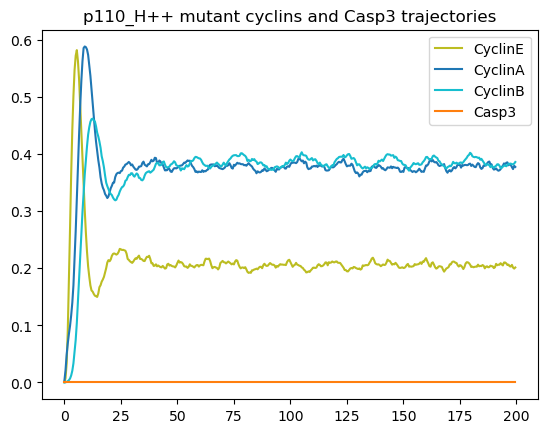

In [45]:
# Simulation of the mutant model
%time res_mut_p110 = mut_p110.run()
res_mut_p110.plot_node_trajectory()
plt.title('p110_H++ mutant cyclins and Casp3 trajectories')

Text(0.5, 1.0, 'p110_H++ mutant Compressed state transition graph of cyclins and Casp3')

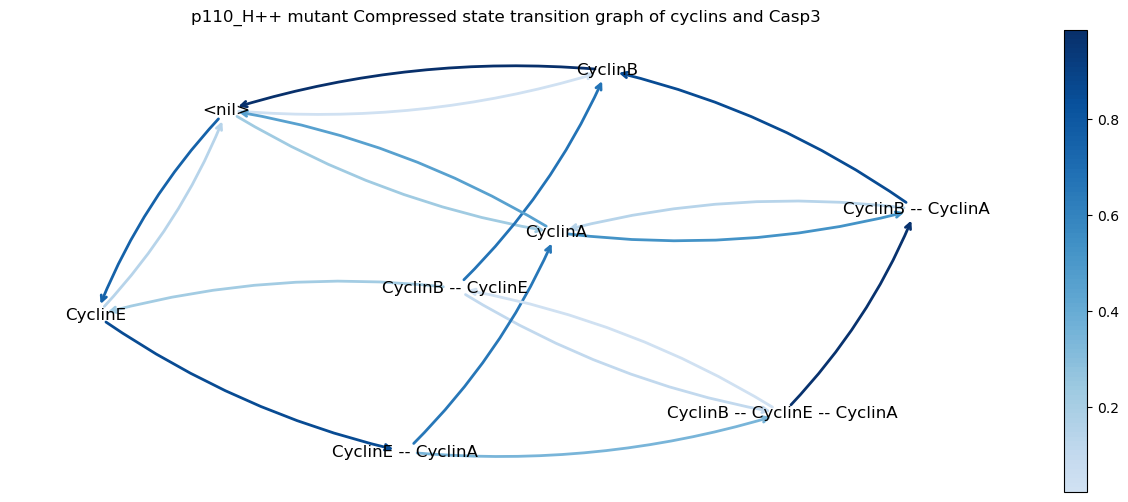

In [46]:
# Plot the compressed transition graph
fig, ax = plt.subplots(1,1,figsize=(16,6))
res_mut_p110.plot_observed_graph(axes=ax, prob_cutoff=0.02)
plt.title('p110_H++ mutant Compressed state transition graph of cyclins and Casp3')

As can be seen in the resulting graph, the ectopic activity of p110_H completely disables the activation of apoptosis, enabling the maintenance of the oscillatory behaviour. 

## 4. Conclusion

After providing the instructions to install the 20 different tools integrated in the *CoLoMoTo* software suite, this tutorial focused on the analysis of a published model of the regulatory network controlling mammalian cell proliferation [13].

The tutorial includes python code enabling the reproduction of several of the results reported by Sizek et al., as well as to further extend these results. Using selected tools included in the *CoLoMoTo* suite, we showed how to compute the model attractors with synchronous or asynchronous updating. Although stable states are naturally preserved, our analysis emphasises the sensitivity of synchronous cyclic attractors to update mode.

We further showed how the use of a probabilistic simulation framework, implemented in the *MaBoSS* software, can provide interesting information on the transient behaviour of such a complex model, for wild-type conditions, as well as for different types of model perturbations. 

Integrating all these analyses into an executable *Jupyter* notebook greatly facilitates their reproducibility, as well as extensions. The notebook can also be used as a template for encoding completely new model analyses.

Due to space constraints, this notebook explicitly covers the use of only a fraction of the tools available in the *CoLoMoTo* collection. However, all integrated tools are accompanied by short specific tutorials available in the *CoLoMoTo Docker* container, as well as on the *CoLoMoTo* website.

**Data accessibility.**    
The notebook and required companion files are available at https://github.com/colomoto/colomoto-tutorial-sizek. The source notebook file (with a .ipynb extension) can be uploaded and executed within the Jupyter interface of the CoLoMoTo notebook, using the Docker image `colomoto/colomoto-docker:2025-01-01`.

**Competing interests.**   
We declare we have no competing interests. 

**Funding.**   
This work has been supported by the French Plan Cancer-MIC ITMO, Project MoDICeD (No. 20CM114-00), and by the French Agence Nationale pour la Recherche (ANR) in the scope of the project ``BNeDiction'' (grant number ANR-20-CE45-0001), and France 2030 project "AI4scMED’’ operated by ANR (grant number ANR-22-PESN-0002).

## References
1) Sugita M. Functional analysis of chemical systems in vivo using a logical circuit equivalent. II. The idea of a molecular automaton. *J Theor Biol* 1963; **4**: 179-184. (doi:10.1016/0022-5193(63)90027-4)
2) Kauffman SA. Metabolic stability and epigenesis in randomly constructed genetic nets. *J Theor Biol* 1969; **22**: 437-467. (doi:10.1016/0022-5193(69)90015-0)
3) Thomas R. Boolean formalization of genetic control circuits.  *J Theor Biol* 1973; **42**: 563-585. (doi:10.1016/0022-5193(73)90247-6)
4) Albert R, Thakar J. Boolean modeling: a logic-based dynamic approach for understanding signaling and regulatory networks and for making useful predictions. *WIREs Syst Biol Med* 2014; **6**: 353-369. (doi:10.1002/wsbm.1273)
5) Abou-Jaoudé W, Traynard P, Monteiro P, Saez-Rodriguez J, Helikar T, Thieffry D, Chaouiya D. Logical modeling and dynamical analysis of cellular networks.  *Front Genet* 2016; **7**: 94. (doi:10.3389/fgene.2016.00094)
6) Schwab JD, Kühlwein SD, Ikonomi N, Kühl M, Kestler HA. Concepts in Boolean network modeling: What do they all mean? Comput Struct Biotechnol J. 2020; 18: 571-582 (doi:10.1016/j.csbj.2020.03.001)
7) Thakar J. Pillars of biology: Boolean modeling of gene-regulatory networks. *J Theor Biol* 2024; **578**: 111682. (doi:10.1016/j.jtbi.2023.111682)
8) Zerrouk N, Augé F, Niarakis A. Building a modular and multi-cellular virtual twin of the synovial joint in Rheumatoid Arthritis. *NPJ Digit Med* 2024; **7**: 379. (doi:10.1038/s41746-024-01396-y)
9) Hemedan AA, Niarakis A, Schneider R, Ostaszewski M. Boolean modelling as a logic-based dynamic approach in systems medicine. *Comput Struct Biotechnol J* 2022; **20**: 3161-3172. (doi:10.1016/j.csbj.2022.06.035)
10) Tiwari  K , Kananathan  S , Roberts  MG , Meyer  JP , Shohan  MUS , Xavier  A , Maire  M, Zyoud  A , Men  J , Ng  S ,  Nguyen  TVN , Glont  M , Hermjakob  H , Malik-Sheriff  RS. Reproducibility in systems biology modelling. *Mol Syst Biol* 2021; **17**: e9982. (doi: 10.15252/msb.20209982)
11) Chaouiya C, Berenguier D, Keating SK, Naldi A, van Iersel MP, Rodriguez N, Dräger A, Büchel F, Cokelaer T, Kowal B, Wicks B, Gonçalves E, Dorier J, Page M, Monteiro PT, von Kamp A, Xenarios I, de Jong H, Hucka M, Klamt S, Thieffry D, Le Novère N, Saez-Rodriguez J, Helikar T. SBML qualitative models: a model representation format and infrastructure to foster interactions between qualitative modelling formalisms and tools. *BMC Syst Biol* 2013; **7**: 135. (doi:10.1186/1752-0509-7-135)
12) Naldi A, Hernandez C, Levy N, Stoll G, Monteiro PT, Chaouiya C, Helikar T, Zinovyev A, Calzone L, Cohen-Boulakia S, Thieffry D, Paulevé L. The CoLoMoTo Interactive Notebook: Accessible and Reproducible Computational Analyses for Qualitative Biological Networks.  *Front Physiol* 2018; **9**: 680. (doi:10.3389/fphys.2018.00680)
13) Sizek  H , Hamel  A , Deritei D , Campbell  S , Regan ER.  Boolean model of growth signaling, cell cycle and apoptosis predicts the molecular mechanism of aberrant cell cycle progression driven by hyperactive PI3K. *PLoS Comput Biol* 2019; **15**: e1006402. (doi:10.1371/journal.pcbi.1006402)
14) Naldi A, Hernandez C, Abou-Jaoudé W, Monteiro PT, Chaouiya C, Thieffry D. Logical modelling and analysis of cellular regulatory networks with GINsim 3.0. *Front Physiol* 2018; **9**: 646. (doi:10.3389/fphys.2018.00646)
15) Naldi A. BioLQM: A Java Toolkit for the Manipulation and Conversion of Logical Qualitative Models of Biological Networks. *Front Physiol* 2018; **9**: 1605. (doi:10.3389/fphys.2018.01605)
16) Naldi A, Remy E, Thieffry D, Chaouiya C. Dynamically consistent reduction of logical regulatory graphs. *Theor Comput Sci* 2011; **412**: 2207-2218. (doi:10.1016/j.tcs.2010.10.021)
17) Stoll G, Caron B, Viara E, Dugourd A, Zinovyev A, Naldi A, Kroemer G, Barillot E, Calzone L. MaBoSS 2.0: an environment for stochastic Boolean modeling. *Bioinformatics* 2017; **33**: 2226-2228. (doi:0.1093/bioinformatics/btx123).
